In [1]:
# Robert Malongo
# Facebook advertising campaign
# 05/06/2020

# For data manipulation
import pandas as pd
import numpy as np

# For visualizations
import seaborn as sns
sns.set()
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from mpl_toolkits.mplot3d import Axes3D

# For Training and testing
from sklearn.model_selection import train_test_split
# cross validation machinery
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [2]:
# Import data
arc_df = pd.read_csv("Analytics___Data_Science_Summer_Associate_Exercise_Data.csv")

In [3]:
# Dataframe structure
arc_df.shape

(259, 19)

In [4]:
# First Five 5 observations
arc_df.head()

,Ad_Set_Name,Age,Gender,Reach,Frequency,Amount Spent (USD),Impressions,"CPM (Cost per 1,000 Impressions) (USD)",Link Clicks,CPC (Cost per Link Click) (USD),CTR (Link Click-Through Rate),"Cost per 1,000 People Reached (USD)",Website Registrations Completed,Website Leads,Post Shares,Post Comments,Post Reactions,Cost per Website Registration Completed (USD),Cost per Website Lead (USD)
0,Ad Set 1,35-44,unknown,152,1.421053,3.12,216,14.444444,NaN,NaN,NaN,20.526316,NaN,NaN,1.0,NaN,5.0,NaN,NaN
1,Ad Set 1,35-44,female,6777,1.091486,101.53,7397,13.725835,21.0,4.834762,0.283899,14.981555,NaN,NaN,30.0,8.0,258.0,NaN,NaN
2,Ad Set 1,35-44,male,6041,1.191359,70.83,7197,9.841601,21.0,3.372857,0.291788,11.724880,NaN,5.0,50.0,18.0,283.0,NaN,14.166
3,Ad Set 1,25-34,unknown,314,1.000000,3.34,314,10.636943,1.0,3.340000,0.318471,10.636943,NaN,NaN,2.0,2.0,9.0,NaN,NaN
4,Ad Set 1,25-34,male,7184,1.092567,63.25,7849,8.058351,20.0,3.162500,0.254810,8.804287,NaN,2.0,36.0,28.0,218.0,NaN,31.625


# Data Cleaning & Preparation
* Check and impute NAs
* Rename columns for quicker selection
* Create new features: Conversion rates - To be used as outcome feature in predictive model
* Check for multicollinearity 
* Select features that are not linearly dependent on each other: e.g *Reach* vs *Link Clicks*: you can't have a nonzero value on *Link Clicks* when *Reach* = 0

**Assumptions**
* **NA** in some columns means no action taken by the customer. For example **NAs** in *Website Registrations Completed* column means that the customer did not complete registration hence 0 registrations for the specific *Ad Set*
* Cost per Website Registration Completed (CPR) = Customer Acquisition Cost

In [5]:
# Check for NAs per column
arc_df.isna().sum()

Ad_Set_Name                                        0
Age                                                0
Gender                                             0
Reach                                              0
Frequency                                          0
Amount Spent (USD)                                 0
Impressions                                        0
CPM (Cost per 1,000 Impressions) (USD)             0
Link Clicks                                       62
CPC (Cost per Link Click) (USD)                   62
CTR (Link Click-Through Rate)                     62
Cost per 1,000 People Reached (USD)                0
Website Registrations Completed                  159
Website Leads                                    113
Post Shares                                      140
Post Comments                                    180
Post Reactions                                    98
Cost per Website Registration Completed (USD)    159
Cost per Website Lead (USD)                   

In [6]:
# Missing Values imputation with 0
arc_df[['Website Registrations Completed','Post Shares','Post Comments','Post Reactions' , 'Link Clicks']] = arc_df[['Website Registrations Completed', 'Post Shares', 'Post Comments','Post Reactions' , 'Link Clicks']].fillna(value=0)

In [7]:
# Rename columns
arc_df.rename(columns = {'CPM (Cost per 1,000 Impressions) (USD)':'cpm', 'Link Clicks': 'link_clicks'},inplace = True)
arc_df.rename(columns = {'CPC (Cost per Link Click) (USD)':'cpc', 'CTR (Link Click-Through Rate)': 'ctr'},inplace = True)
arc_df.rename(columns = {'Cost per 1,000 People Reached (USD)': 'cppr', 'Website Leads': 'website_leads' },inplace = True)
arc_df.rename(columns = {'Post Shares': 'post_shares', 'Post Reactions':'post_reactions', 'Post Comments': 'post_comments' },inplace = True)
arc_df.rename(columns = {'Website Registrations Completed':'reg_completed', 'Amount Spent (USD)': 'amount_spent'},inplace = True)
arc_df.rename(columns = {'Cost per Website Registration Completed (USD)':'cpr', 'Cost per Website Lead (USD)': 'cpl'},inplace = True)

In [8]:
# Create new features : Conversion rates based on completed registrations, reach and impressions
arc_df['conv_rate_1'] = (arc_df.reg_completed/arc_df.Reach)*100
arc_df['conv_rate_2'] = (arc_df.reg_completed/arc_df.Impressions)*100

In [9]:
# Check for Correlations
arc_df.corr(method ='pearson')

,Reach,Frequency,amount_spent,Impressions,cpm,link_clicks,cpc,ctr,cppr,reg_completed,website_leads,post_shares,post_comments,post_reactions,cpr,cpl,conv_rate_1,conv_rate_2
Reach,1.000000,0.249212,0.973288,0.995098,-0.084762,0.958833,-0.257044,0.124054,0.107476,0.906966,0.858857,0.640184,0.734287,0.461024,-0.038099,-0.095636,0.262226,0.261039
Frequency,0.249212,1.000000,0.243746,0.251540,-0.090739,0.224271,-0.360729,0.222893,0.696325,0.189809,0.206669,0.233789,0.204071,0.177871,-0.060672,-0.152867,0.170199,0.202142
amount_spent,0.973288,0.243746,1.000000,0.972645,-0.027338,0.974169,-0.243556,0.164131,0.169959,0.933965,0.909855,0.612483,0.678393,0.395461,-0.033215,-0.116144,0.281771,0.278333
Impressions,0.995098,0.251540,0.972645,1.000000,-0.087423,0.960163,-0.254006,0.125512,0.104521,0.911610,0.850910,0.670319,0.734013,0.462771,-0.054560,-0.104242,0.257170,0.249860
cpm,-0.084762,-0.090739,-0.027338,-0.087423,1.000000,-0.049142,0.298700,0.122370,0.401479,-0.032168,-0.058327,-0.139935,-0.173876,-0.209246,0.055919,0.069379,0.099472,0.086696
link_clicks,0.958833,0.224271,0.974169,0.960163,-0.049142,1.000000,-0.272973,0.228534,0.127803,0.923873,0.946264,0.561966,0.675178,0.344307,-0.058258,-0.152842,0.253447,0.243433
cpc,-0.257044,-0.360729,-0.243556,-0.254006,0.298700,-0.272973,1.000000,-0.666967,0.124283,-0.195718,-0.268627,-0.142953,-0.173388,-0.032727,-0.137433,0.209229,-0.074813,-0.041393
ctr,0.124054,0.222893,0.164131,0.125512,0.122370,0.228534,-0.666967,1.000000,0.245468,0.143311,0.347425,-0.049436,-0.015742,-0.216701,0.100090,-0.296840,0.019086,-0.000403
cppr,0.107476,0.696325,0.169959,0.104521,0.401479,0.127803,0.124283,0.245468,1.000000,0.118017,0.069227,0.029973,-0.027304,-0.088348,0.039545,-0.021475,0.186010,0.259528
reg_completed,0.906966,0.189809,0.933965,0.911610,-0.032168,0.923873,-0.195718,0.143311,0.118017,1.000000,0.909776,0.504456,0.582216,0.323425,-0.240266,-0.181613,0.343720,0.335812


In [10]:
# Select relevant columns only: Drop correlated or variabels that are linearly dependent with conv_rate_1
df_sum = arc_df.drop(['cpm','amount_spent', 'cpc', 'ctr', 'cppr', 'website_leads', 'cpl', 'link_clicks', 'Impressions', 'post_comments'], axis=1)

# Descriptive statistics
* Ad campaign is targeting people aged 25-44 years
    * More likely to be on FB, pay utilities for apartment/house and view clean energy more favorably
    * But Conversion rate is very low (max = 0.41% ~ 4 acquired customers for every 1000 reached) 
* Ad frequency has positive impact in increasing completed registrations & conversion rates
* Ad reactions is associated with high conversion rate
* Currently, almost 50:50 split for target acquisition cost of USD50 per customer
    * 49% of ads have CPR below USD50
    * 51% of ads have CPR above USD50
    * Need to redesign strategy for ads whose CPR is above USD50
* Minimal conversion rate differences across gender and age groups

In [11]:
# All Numerical 
df_sum.describe()

,Reach,Frequency,reg_completed,post_shares,post_reactions,cpr,conv_rate_1,conv_rate_2
count,259.000000,259.000000,259.000000,259.000000,259.000000,100.000000,235.000000,259.000000
mean,3671.100386,1.010491,2.208494,4.243243,15.915058,64.394784,0.032835,0.026204
std,7308.108027,0.356852,6.699746,10.603436,39.319509,42.744967,0.055902,0.046121
min,0.000000,0.000000,0.000000,0.000000,0.000000,9.030000,0.000000,0.000000
25%,116.000000,1.000000,0.000000,0.000000,0.000000,35.511250,0.000000,0.000000
50%,936.000000,1.030817,0.000000,0.000000,1.000000,50.271917,0.000000,0.000000
75%,3762.000000,1.179984,1.000000,3.000000,10.000000,76.292500,0.054590,0.042340
max,53824.000000,2.325893,72.000000,100.000000,283.000000,207.900000,0.416667,0.296736


In [12]:
# Add Campaign is mostly targeting young - middle age customers
df_sum['Age'].value_counts()

25-34    115
35-44    114
45-54     14
65+        9
18-24      4
55-64      3
Name: Age, dtype: int64

In [13]:
# Small variation in gender being targetted
df_sum['Gender'].value_counts()

male       92
female     89
unknown    78
Name: Gender, dtype: int64

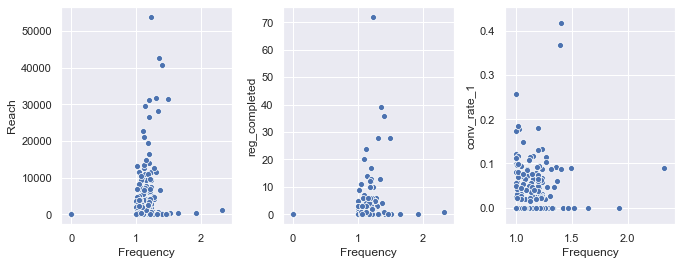

In [14]:
# Ad Frequency
plt.subplot(1,3,1)
sns.scatterplot(x="Frequency", y="Reach", data=df_sum)

plt.subplot(1,3,2)
sns.scatterplot(x="Frequency", y="reg_completed", data=df_sum)

plt.subplot(1,3,3)
sns.scatterplot(x="Frequency", y="conv_rate_1", data=df_sum)

# Aesthetics
plt.subplots_adjust(wspace = 0.3, hspace = 0)
fig = plt.gcf()
fig.set_figheight(4)
fig.set_figwidth(11)
plt.show()

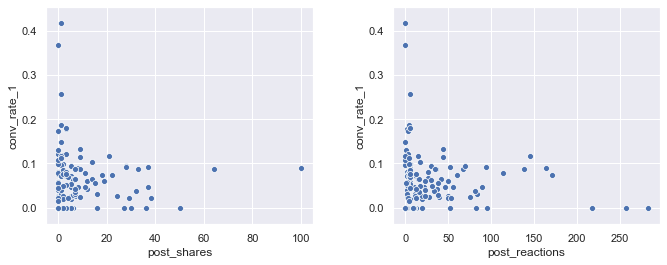

In [15]:
#Ad activity
plt.subplot(1,2,1)
sns.scatterplot(x="post_shares", y="conv_rate_1", data=df_sum)

plt.subplot(1,2,2)
sns.scatterplot(x="post_reactions", y="conv_rate_1", data=df_sum)

# Aesthetics
plt.subplots_adjust(wspace = 0.3, hspace = 0)
fig = plt.gcf()
fig.set_figheight(4)
fig.set_figwidth(11)
plt.show()

In [16]:
# Bins for cpr: Total Acquisiton costs 
# Target is $50 or less hence create bins to for cpr
bins_cpr = [0,50,np.inf]
df_sum['cpr'].value_counts(bins =bins_cpr)

(50.0, inf]       51
(-0.001, 50.0]    49
Name: cpr, dtype: int64

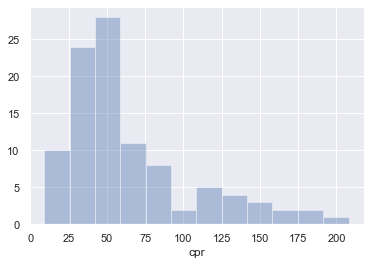

In [17]:
# cpr = proxy for customer acqusition
sns.distplot(df_sum['cpr'], kde=False)

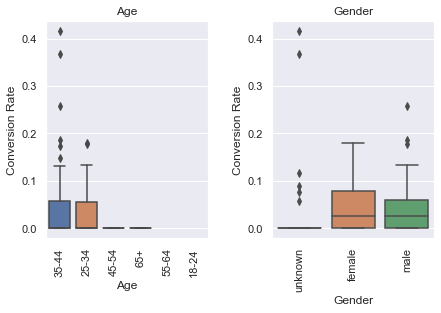

In [18]:
# Categorical features
plt.subplot(1,3,1)
sns.boxplot(x='Age', y="conv_rate_1", data=df_sum)
plt.title("Age")
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.boxplot(x='Gender', y="conv_rate_1", data=df_sum)
plt.title("Gender")
plt.ylabel('Conversion Rate')
plt.xticks(rotation=90)

plt.subplots_adjust(wspace= 0.4, hspace = 0.1)
fig = plt.gcf()
fig.set_figheight(4)
fig.set_figwidth(11)
plt.show()

# Machine Learning Algorithms

* Design a Predictive model for Conversion rate 
* Want to know which set of features can increase conversion rate
* Using Conversion rate computed with Reach since purpose of campaign is **Customer Acquisition**: This rate will help to figure out whether there’s something wrong with the ad set
* Conversion rate is a continuous feature hence will consider only regression based models. Will use:
  * Linear regression
  * KNN Regression
  * Random Forest Regression

In [19]:
# Monte Carlo Function
# Set up Monte-carlo experiment
def MCtraintest(nmc,X,y,modelObj,testFrac):
    trainScore = np.zeros(nmc)
    testScore  = np.zeros(nmc)
    for i in range(nmc):
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=testFrac)
        modelObj.fit(X_train,y_train)
        trainScore[i] = modelObj.score(X_train,y_train)
        testScore[i]  = modelObj.score(X_test,y_test)
    return trainScore,testScore

# Set parameters 
nmc = 25
testFrac = 0.25

In [20]:
# Drop some more features since we don't need them for ML for reasons explaned earlier
df_sum = df_sum.drop(['reg_completed','cpr', 'post_shares', 'Ad_Set_Name','conv_rate_2'], axis=1)
# Missing Values imputation
# Drop missing conversion rates: created by (0/0) where reach (denominator) = 0
df_sum = df_sum.dropna() 
# One-hot encoding: Age & gender
df_ml = pd.get_dummies(df_sum, prefix=['age', 'gender'], columns=['Age', 'Gender'])
# Create y and X features
y = df_ml['conv_rate_1']
X = df_ml.drop(['conv_rate_1'], axis=1)

In [21]:
# X Features
X.columns

Index(['Reach', 'Frequency', 'post_reactions', 'age_25-34', 'age_35-44',
       'age_45-54', 'age_65+', 'gender_female', 'gender_male',
       'gender_unknown'],
      dtype='object')

In [22]:
# y feature
y.name

'conv_rate_1'

## Linear Regression
* Default parameters

In [23]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
shuffle = ShuffleSplit(n_splits=100, test_size=.25, random_state=25)
CVInfo = cross_validate(lr, X, y, cv=shuffle,return_train_score=True)
print(np.mean(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))

0.14245281638779103
0.09550575166328432


## Ridge Regression
* Default parameters
* Grid search
* Best model

In [24]:
from sklearn.linear_model import Ridge
fullModel = make_pipeline(StandardScaler(), Ridge(alpha=10))
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullModel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.1489
Testing Set Accuracy: 0.0829


In [25]:
# Supress warnings
import warnings
warnings.filterwarnings("ignore")

# Grid search
alphalist = np.power(10.,range(-31,0,2))
fullModel = make_pipeline(StandardScaler(),Ridge())
# set up dictionary for grid search
# dictionary name must now include pipeline function name then __
param_grid={'ridge__alpha':alphalist, 'ridge__max_iter':[100000]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=25)
# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_ridge__alpha']].round(5)

# Highlight Orange best model Function
def highlight_col(x):
    # copy df to new - original data are not changed
    df = x.copy()
    # Hightlight orange highest ranked model
    mask = df['rank_test_score'] == 1
    df.loc[mask, :] = 'background-color: orange'
    df.loc[~mask,:] = 'background-color: ""'
    return df 

# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_ridge__alpha
0,16,0.150250,0.058180,0.000000
1,15,0.161120,0.066850,0.000000
2,2,0.162420,0.067140,0.000000
3,4,0.162420,0.067140,0.000000
4,6,0.162420,0.067140,0.000000
5,8,0.162420,0.067140,0.000000
6,10,0.162420,0.067140,0.000000
7,12,0.162420,0.067140,0.000000
8,14,0.162420,0.067140,0.000000
9,13,0.162420,0.067140,0.000000


Text(0.5, 1.0, 'Regularization in Ridge')

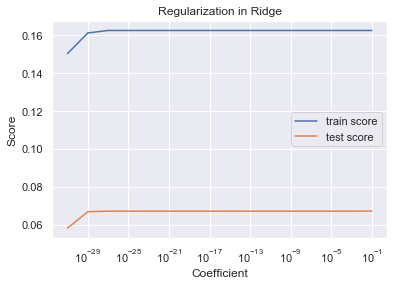

In [26]:
# Regularization Plot
plt.semilogx(alphalist, df_results['mean_train_score'],label="train score")
plt.semilogx(alphalist, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Coefficient")
plt.legend()
plt.title("Regularization in Ridge")

## Lasso Regression
* Default parameters
* Grid search
* Best model
* Feature selection

In [27]:
from sklearn.linear_model import Lasso
fullModel = make_pipeline(StandardScaler(), Lasso(alpha=0.01, max_iter=100000))
shuffle = ShuffleSplit(n_splits=25, test_size=.25, random_state=0)
CVInfo = cross_validate(fullModel, X, y, cv=shuffle,return_train_score=True)
print("Training Set Accuracy: {:.4f}".format(np.mean(CVInfo['train_score'])))
print("Testing Set Accuracy: {:.4f}".format(np.mean(CVInfo['test_score'])))

Training Set Accuracy: 0.0543
Testing Set Accuracy: 0.0077


In [28]:
# Suppress warnings
warnings.filterwarnings("ignore")

# Grid search
alphalist = np.power(10.,range(-31,0,2))
fullModel = make_pipeline(StandardScaler(),Lasso())
# set up dictionary for grid search
# dictionary name must now include pipeline function name then __
param_grid={'lasso__alpha':alphalist, 'lasso__max_iter':[100000]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=25)
# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_lasso__alpha']]

# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_lasso__alpha
0,8,0.156573,0.057374,0.000000
1,8,0.156573,0.057374,0.000000
2,8,0.156573,0.057374,0.000000
3,8,0.156573,0.057374,0.000000
4,8,0.156573,0.057374,0.000000
5,8,0.156573,0.057374,0.000000
6,14,0.156573,0.057374,0.000000
7,7,0.156573,0.057374,0.000000
8,6,0.156573,0.057374,0.000000
9,5,0.156573,0.057374,0.000000


Text(0.5, 1.0, 'Regularization in Lasso')

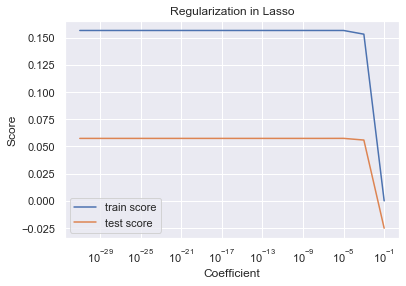

In [29]:
# Regularization Plot
plt.semilogx(alphalist, df_results['mean_train_score'],label="train score")
plt.semilogx(alphalist, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Coefficient")
plt.legend()
plt.title("Regularization in Lasso")

Text(0, 0.5, 'Feature')

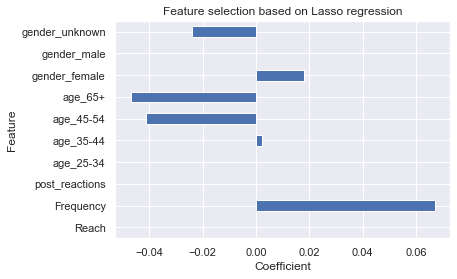

In [30]:
# Feature selection based on Lasso
from sklearn.metrics import explained_variance_score 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)  
lasso = Lasso(alpha=0.00001, normalize=True)  
lasso.fit(X_train, y_train)  
lasso_coefs = (pd.Series(lasso.coef_, index=X.columns)) 
lasso_coefs.plot(kind='barh')
plt.title('Feature selection based on Lasso regression')  
plt.xlabel('Coefficient') 
plt.ylabel('Feature') 

## KNN Regressor
* Default parameters
* Grid search
* Best model

In [31]:
from sklearn.neighbors import KNeighborsRegressor
cvshuffle = ShuffleSplit(n_splits=100, test_size= 0.5, random_state=25)
fullModel = make_pipeline(StandardScaler(),KNeighborsRegressor())
CVInfo= cross_validate(fullModel, X, y, cv=cvshuffle, return_train_score=True)
print(np.mean(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))

0.28235399592882987
-0.1576788533709763


In [32]:
# Grid search
neighborRange = np.arange(1,52,5)
fullModel = make_pipeline(StandardScaler(),KNeighborsRegressor())
# set up dictionary for grid search
# dictionary name must now include pipeline function name then __
param_grid={'kneighborsregressor__n_neighbors':neighborRange}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=100)
# set up search
grid_search=GridSearchCV(fullModel,param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_kneighborsregressor__n_neighbors']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_kneighborsregressor__n_neighbors
0,11,1.000000,-0.359560,1
1,10,0.286492,-0.135522,6
2,9,0.144583,-0.073027,11
3,8,0.129880,0.008403,16
4,7,0.108841,0.019334,21
5,6,0.092802,0.020676,26
6,5,0.085559,0.027353,31
7,4,0.080691,0.029372,36
8,3,0.085119,0.044027,41
9,2,0.086329,0.049158,46


Text(0.5, 1.0, 'Regularization in Nearest Neighbour')

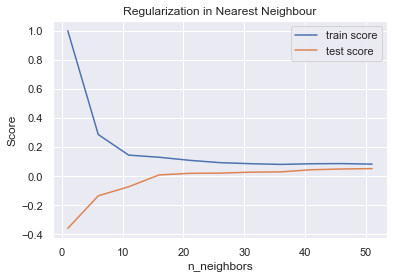

In [33]:
# Regularization Plot
plt.plot(neighborRange,df_results['mean_train_score'],label="train score")
plt.plot(neighborRange,df_results['mean_test_score'], label="test score")
plt.ylabel("Score")
plt.xlabel("n_neighbors")
plt.legend()
plt.title("Regularization in Nearest Neighbour")

## Decision Tree  Regressor
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Tree
    * Model importances

In [34]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
shuffle = ShuffleSplit(n_splits=100, test_size=.25, random_state=25)
CVInfo = cross_validate(dt, X, y, cv=shuffle,return_train_score=True)
print(np.mean(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))

0.9999998419985152
-0.6017818706074975


In [35]:
# Grid Search
# Parameters
tree_depth = np.arange(start=2,stop=41,step=2,dtype=int)
param_grid={'max_depth':tree_depth}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(DecisionTreeRegressor(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_max_depth']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_max_depth
0,2,0.328413,-0.446458,2
1,1,0.592899,-0.236459,4
2,3,0.744652,-0.460781,6
3,4,0.859121,-0.583751,8
4,8,0.928758,-0.694068,10
5,7,0.970703,-0.684896,12
6,6,0.988857,-0.663048,14
7,11,0.995108,-0.715937,16
8,20,0.998383,-0.903269,18
9,17,0.999629,-0.835662,20


Text(0.5, 1.0, 'Regularization in Decision Trees')

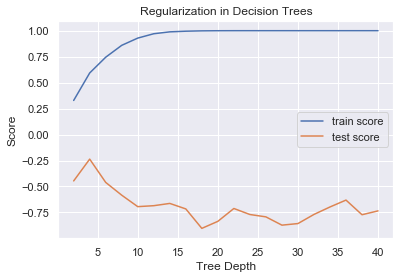

In [36]:
# Plot
plt.plot(tree_depth, df_results['mean_train_score'],label="train score")
plt.plot(tree_depth, df_results['mean_test_score'],label="test score")
plt.ylabel("Score")
plt.xlabel("Tree Depth")
plt.legend()
plt.title("Regularization in Decision Trees")

In [50]:
# Analyze tree
X_train, X_test, y_train, y_test = train_test_split(X,y)
dt = DecisionTreeRegressor(max_depth=2, random_state=0)
dt.fit(X_train, y_train)

print("Training Set Accuracy: {:.4f}".format(dt.score(X_train, y_train)))
print("Testing Set Accuracy: {:.4f}".format(dt.score(X_test, y_test)))

Training Set Accuracy: 0.5244
Testing Set Accuracy: 0.1154


In [51]:
# Tree
from sklearn.tree import export_graphviz
export_graphviz(dt, out_file="tree.dot",feature_names= X.columns, impurity=False, filled=True)

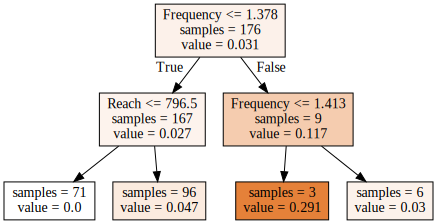

In [52]:
import graphviz 
with open("tree.dot") as f:
    dot_graph = f.read()
    display(graphviz.Source(dot_graph))

## Random Forest Regressor
* Default parameters
* Grid search
* Best Model
* Model Interpretation
    * Model Importances
    * Partial Dependence

In [40]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()
shuffle = ShuffleSplit(n_splits=100, test_size=.25, random_state=25)
CVInfo = cross_validate(rf, X, y, cv=shuffle,return_train_score=True)
print(np.mean(CVInfo['train_score']))
print(np.mean(CVInfo['test_score']))

0.8822604979650055
0.11336415638816993


In [41]:
# Grid search
max_features_list = np.arange(start=1,stop= 10,step=2,dtype=int)
tree_depth_list   = np.arange(start=1,stop= 12,step=2,dtype=int)
# Set grid search
param_grid={'max_features':max_features_list,'max_depth':tree_depth_list,'n_estimators':[10]}
# set up cross-validation shuffles
cvf = ShuffleSplit(test_size=0.25,n_splits=nmc)
# set up search
grid_search=GridSearchCV(RandomForestRegressor(),param_grid,cv=cvf,return_train_score=True)
# implement search
grid_search.fit(X,y)
# move results into DataFrame
results = pd.DataFrame(grid_search.cv_results_)
df_results = results[['rank_test_score','mean_train_score','mean_test_score','param_max_depth', 'param_max_features', 'param_n_estimators']]
# Table for Grid search results
df_results.style.apply(highlight_col, axis=None)

,rank_test_score,mean_train_score,mean_test_score,param_max_depth,param_max_features,param_n_estimators
0,20,0.065696,0.056253,1,1,10
1,10,0.133760,0.085929,1,3,10
2,6,0.156458,0.100260,1,5,10
3,2,0.170511,0.112140,1,7,10
4,19,0.175019,0.059611,1,9,10
5,3,0.274235,0.108972,3,1,10
6,11,0.400219,0.085109,3,3,10
7,15,0.501276,0.076987,3,5,10
8,4,0.549322,0.108153,3,7,10
9,24,0.567486,0.021188,3,9,10


In [42]:
# Best Model and Feature importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25,random_state=0)
rf = RandomForestRegressor(max_features = 3,max_depth = 5 ,n_estimators =10)
rf = rf.fit(X_train, y_train)

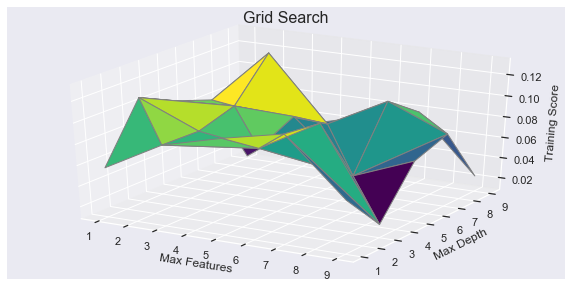

In [56]:
# 3D plot of Grid search results
from matplotlib import cm
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

xs = df_results['param_max_features']
ys = df_results['param_max_depth']
zs = df_results['mean_test_score']

ax.set_xlabel("Max Features",fontsize = 12)
ax.set_ylabel("Max Depth",fontsize = 12)
ax.set_zlabel("Training Score", fontsize = 12)
ax.set_title("Grid Search", fontsize = 16)

# Aesthetics
fig.set_figheight(5)
fig.set_figwidth(10)
                   
ax.plot_trisurf(xs, ys, zs,color= 'blue',edgecolor='gray', cmap=cm.viridis)

Text(0.5, 1.0, 'Feature Importances')

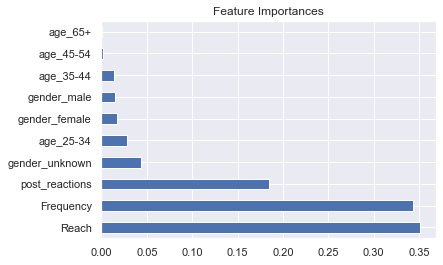

In [58]:
# Display feature importances
importances = rf.feature_importances_
(pd.Series(importances, index=X.columns)
.nlargest(10)
.plot(kind='barh'))
plt.title("Feature Importances")

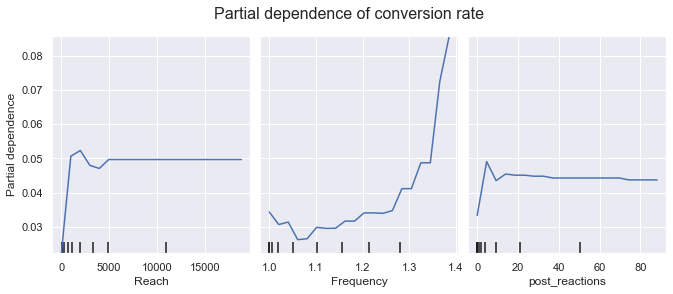

In [45]:
# Partial dependence plot 
from sklearn.inspection import plot_partial_dependence

# Order plots by feuture importance 
features = [0,1,2]
plot_partial_dependence(rf,X,features, grid_resolution=20)
fig = plt.gcf()
fig.suptitle('Partial dependence of conversion rate',fontsize=16)
fig.subplots_adjust(wspace= 0.05, hspace=0.15)
fig.set_figheight(4)
fig.set_figwidth(11)

# Business Insights

* Model with highest Rsquared is Random Forrest Regressor: proportion of variance explained by model
* Reach is most important feature: More unique people reached, more registrations on the platform
    * **Recommendation** 1: Since Ad campaign is within budget, increase frequency of Ad set; can increase frequency of Ad sets for Age group 25-34
* More post reactions, more registrations on the platform especially between 0-10 reactions
    * **Recommendation** 2: Connect with influencers (individuals with defined large following) or industry experts in renewable energy. These can include scientists, business leaders and/or activists who would appreciate the value of company's products. Their positive reactions to the ad can boost conversion rates

**Possible Extensions**
* To maximize **ROI**, would be better to use Customer Lifetime Value (CLTV) as guidance metric to assess financial value of customers in each Ad set
* Know target number of registrations to validate model outcomes
* Tune hyperparameters with grid-search